In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

Using TensorFlow backend.


1. Loading helper functions
2. Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [3]:
model = VGG16(weights="imagenet")
from skimage import io
img = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [4]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

153


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [5]:
from keras import backend as K
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)



1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14
2. Normalize the heat map to make the values between 0 and 1



In [6]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


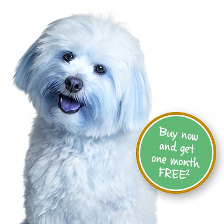

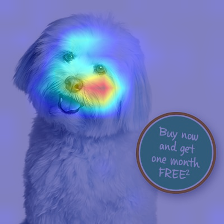

In [7]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( img)
cv2_imshow(superimposed_img)

In [8]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

In [10]:

from keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/resnet 20 with cutout weights /cifar10_ResNet20v1_model.029.h5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
#converting the grad cam code to function whilst replacing last conv layer with our resnet trained conv layer
%matplotlib inline
import cv2
import keras.backend as K

def grad_CAM(img):
    img = img.astype('float32')
    img /= 255
    x = np.expand_dims(img, axis=0)
#     x = preprocess_input(x)


    preds = model.predict(x)  #model
#     print("no cutout")
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]  #moel
    last_conv_layer = model.get_layer("conv2d_21")   # model



    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(64):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    return superimposed_img, preds

In [0]:
#Take 10 images and see if they were rightly classified or wrongly .Since model params loaded at 85% accuracy  
import numpy as np
import matplotlib.pyplot as plt

X_test_wrong = []
X_test_wrong_raw = []

X_test_right = []
X_test_right_raw = []
for i in range(10):  #(len(test_features)):
  img_data = test_features[i].astype('float32')
  img_data /= 255
  img_data = np.expand_dims(img_data, axis=0)
  
  if np.argmax(model.predict(img_data)[0]) != test_labels[i][0]:
    X_test_wrong.append((img_data, np.argmax(model.predict(img_data)[0]), test_labels[i][0]))
    X_test_wrong_raw.append((test_features[i], np.argmax(model.predict(img_data)[0]), test_labels[i][0]))

  else:
     X_test_right.append((img_data, np.argmax(model.predict(img_data)[0]), test_labels[i][0]))
     X_test_right_raw.append((test_features[i], np.argmax(model.predict(img_data)[0]), test_labels[i][0]))


In [14]:
#no wrong classification :) this is pitfall .Model is only 83% accurate at 29th epoch 
len(X_test_wrong_raw)

0

In [15]:
test_labels[i][0]

1

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

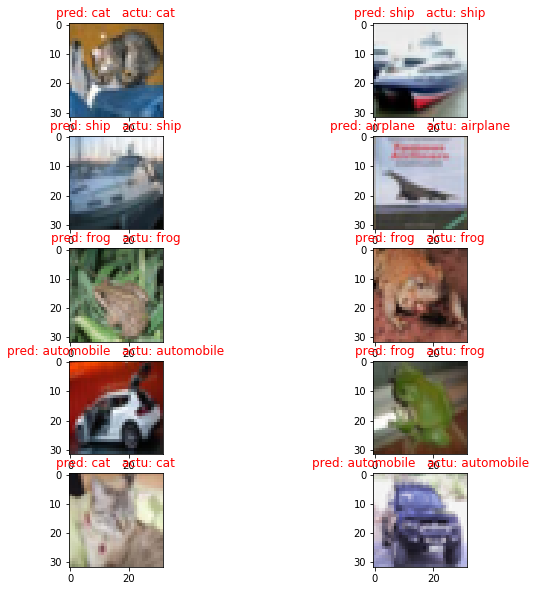

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
batch_size = 5
i = 0
for img in X_test_right:
  ax = plt.subplot(5,2,i+1)
  ax.set_title("pred: {}   actu: {}".format(class_names[img[1]], class_names[img[2]]), color='r')
  plt.imshow(np.reshape(np.uint8(255 * img[0]), (32,32,-1)), cmap=plt.cm.gray)
  i += 1

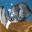

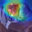

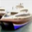

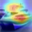

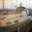

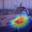

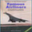

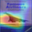

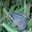

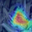

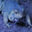

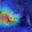

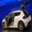

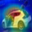

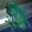

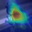

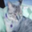

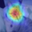

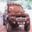

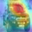

In [18]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from google.colab.patches import cv2_imshow
for i in range(10):
  superimposed_img, preds = grad_CAM(test_features[i])

  cv2_imshow(test_features[i])

  cv2_imshow(superimposed_img) 